In [1]:
import torch
from src.training.funsd import _funsd
import torch.nn as nn
from src.paths import CHECKPOINTS
from src.models.VGAE import GAE, GSage_AE
from src.models.SELF_AEC import SELF_supervised
from src.data.Data_Loaders import FUNSD_loader
import dgl

ModuleNotFoundError: No module named 'src.data.Data_Loaders'

In [2]:
from src.training.utils import (get_model, 
                    compute_crossentropy_loss, 
                    get_optimizer, 
                    get_relative_positons, 
                    load_graphs, 
                    weighted_edges,
                    region_encoding,
                    discrete_positions,
                    discrete_positions_binarize,
                    concat_geom_edge_featurs)

test = FUNSD_loader(train=False)

{   'FEATURES': {   'add_embs': False,
                    'add_eweights': True,
                    'add_fudge': False,
                    'add_geom': True,
                    'add_hist': False,
                    'add_visual': False,
                    'num_polar_bins': 8},
    'GRAPHS': {   'data_type': 'img',
                  'edge_type': 'fully',
                  'node_granularity': 'gt'},
    'LOADER': {   'src_data': 'FUNSD'}}


TEST


Creating graphs - GT:   0%|          | 0/50 [00:00<?, ?it/s]

adding features: 100%|██████████| 50/50 [00:01<00:00, 37.48it/s]


Folder | Nodes | Edges | Info |Kmeans
---|---|---|---|---|
Base_Graph | ['geom', 'feat', 'norm', 'label', 'Geometric'] | ['feat', 'weights', 'label'] | The weights in the edges are the multiplication of the distance unormalized and angle between nodes. The features geometric from the nodes, is a vector for each node containing the position of the bbox, the are of the bbox and a region encoding for the bbox. | No
Distance Node Graph | ['geom', 'feat', 'norm', 'label', 'Geometric'] | ['feat', 'weights', 'label', 'weights_distance'] | Same as Base_Graph but now also has the normalized distance as features in the edges | No
Kmeans_graph |['geom', 'feat', 'norm', 'label', 'Geometric']|['feat', 'weights', 'label'] | The weights contains the unormalized distance | Yes
Discretize_angles | ['geom', 'feat', 'norm', 'label', 'Geometric'] |['feat', 'distance_not_tresh', 'weights', 'label', 'angle', 'distance', 'discrete_bin_edges']| Weights are normalized distance between nodes. Also have angles and distance not tresh | No
Distance_angle | ['geom', 'feat', 'norm', 'label', 'Geometric'] | ['feat', 'weights', 'label'] | weights: angle x (normalized distance) | No
Distance_notresh_angle | ['geom', 'feat', 'norm', 'label', 'Geometric'] | ['feat', 'distance_not_tresh', 'weights', 'label', 'angle', 'distance'] | weights are normalized distance | No

---

In [110]:
import pickle
import dgl

with open('/home/nbiescas/Desktop/CVC/CVC_internship/PKL_Graphs/test_graph_distance_angle.pkl', 'rb') as f:
    test_graph = pickle.load(f)

In [113]:
test_graph[0]

Graph(num_nodes=103, num_edges=10506,
      ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(4,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'Geometric': Scheme(shape=(9,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32), 'distance_not_tresh': Scheme(shape=(), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'angle': Scheme(shape=(), dtype=torch.float32), 'distance': Scheme(shape=(), dtype=torch.float32)})

In [114]:
test_graph[0].edata.keys()

dict_keys(['feat', 'distance_not_tresh', 'weights', 'label', 'angle', 'distance'])

In [117]:
test_graph[0].edata['weights'] 

tensor([0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000])

In [19]:
test_graph[0].edata['feat'].size(

)

torch.Size([10712, 6])

In [9]:
discrete_positions_binarize(test_graph[0].ndata['geom'][7], test_graph[0].ndata['geom'][9])

tensor([1, 0, 0, 1, 0, 0, 0])

In [6]:
discrete_positions_binarize(test_graph[0].ndata['geom'][0], test_graph[0].ndata['geom'][42])

tensor([0, 1, 0, 0, 1, 0, 0])

In [7]:
a = torch.tensor([True, False])
torch.where(a == True, 1, 0) 

tensor([1, 0])

In [2]:
test_graph[3].edges

NameError: name 'test_graph' is not defined

In [48]:
dgl.batch(train_graph)

Graph(num_nodes=7406, num_edges=468658,
      ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(4,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'Geometric': Scheme(shape=(9,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)})

In [17]:
from src.data.Dataset import dataloaders_funsd
from main_utils import LoadConfig
config = LoadConfig('run9')
train_loader, val_loader = dataloaders_funsd(train = True, config = config)
train_graph = dgl.batch([train_graph for train_graph in train_loader])

In [ ]:
import torch

def center(rect):
    new_x = rect[:, [0, 2]].sum(1).unsqueeze(1) / 2
    new_y = rect[:, [1, 3]].sum(1).unsqueeze(1) / 2

    return torch.cat([new_x, new_y], dim=1)

# Create a tensor with the coordinates of the bounding boxes
# Each row contains the coordinates of a bounding box in the format [x1, y1, x2, y2]
# You can replace this with your own tensor
boxes = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 1.0, 1.1, 1.2]])

# Compute the center of each bounding box
centers = center(boxes)

# Compute the indices of the partition for each bounding box
x_indices = (centers[:, 0] / w_chunk).long()
y_indices = (centers[:, 1] / h_chunk).long()
indices = x_indices + y_indices * n

# Group the bounding boxes by partition
partitions = []
for i in range(n * m):
    partition_boxes = boxes[indices == i]
    partitions.append(partition_boxes)

center(train[0].ndata['geom'])

In [164]:
def get_sub_graphs(g, n=0.1, k=10):
    nodes = torch.randperm(g.num_nodes())[:int(g.num_nodes()*n)] # Select 10% of the nodes
    # For each node select the 10 nearest nodes
    center = lambda rect: torch.tensor(((rect[2]+rect[0])/2, (rect[3]+rect[1])/2))
    
    subgprahs = []
    for node_i in nodes:
        distances_i_j = []
        for node_j in g.nodes():
            center_i = center(g.ndata['geom'][node_i])
            center_j = center(g.ndata['geom'][node_j])
            distance_i_j = torch.pow(center_i - center_j, 2).sqrt()
            distances_i_j.append(distance_i_j)
        
        distances_i_j = torch.stack(distances_i_j)
        indices = distances_i_j.sum(dim=1).sort().indices[:k].tolist()
        subgprahs.append(g.subgraph(indices))
    
    return dgl.batch(subgprahs)
    
a = get_sub_graphs(g, 0.1, 10)

#
# torch.pow(g.ndata['geom'][g.out_edges(35)[1].long()] - g.ndata['geom'][35], 2)

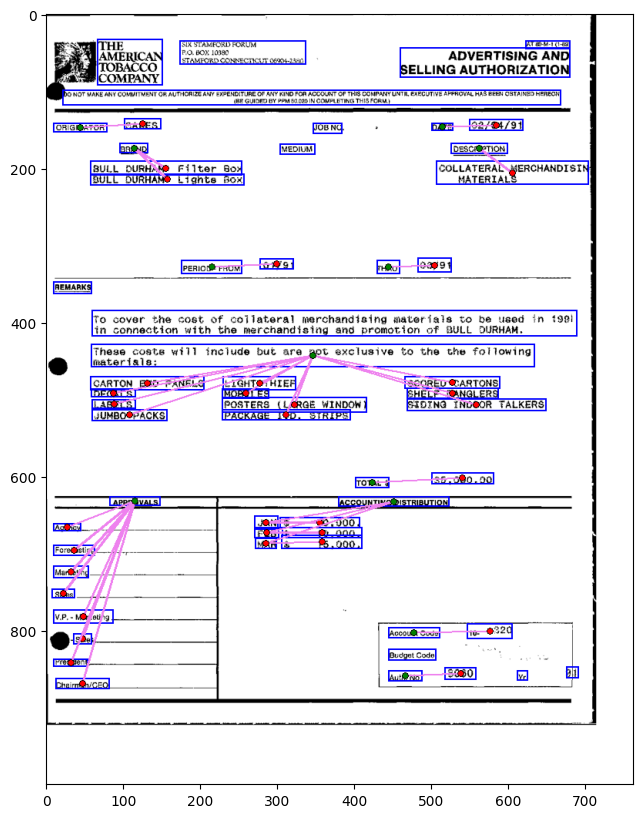

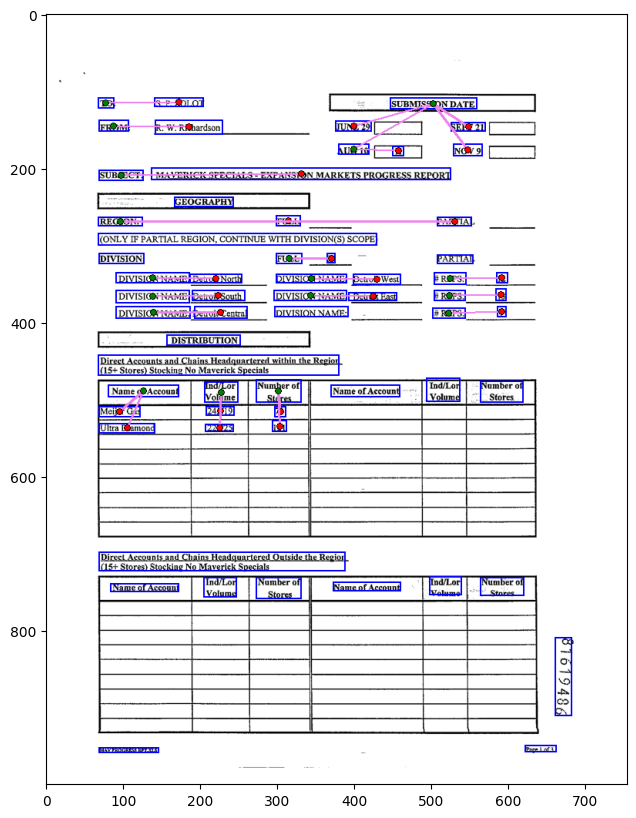

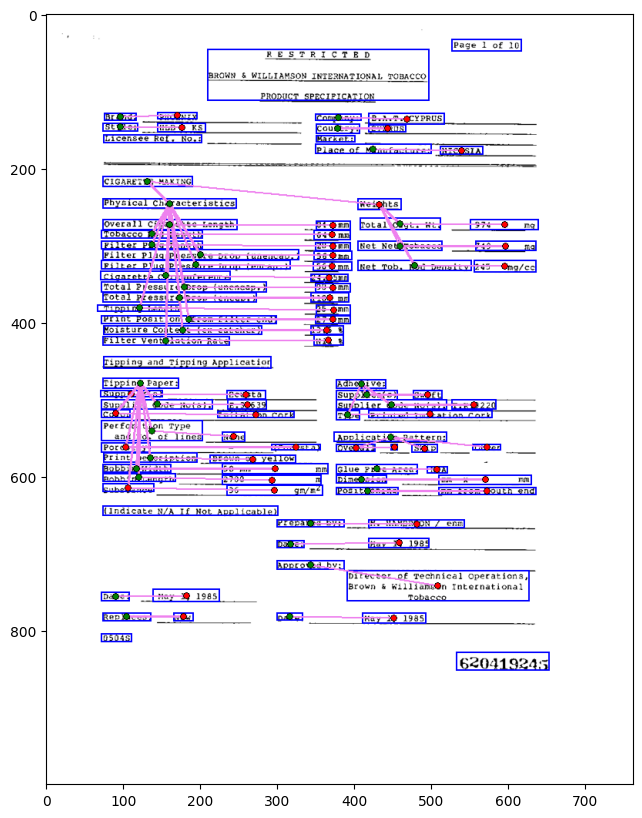

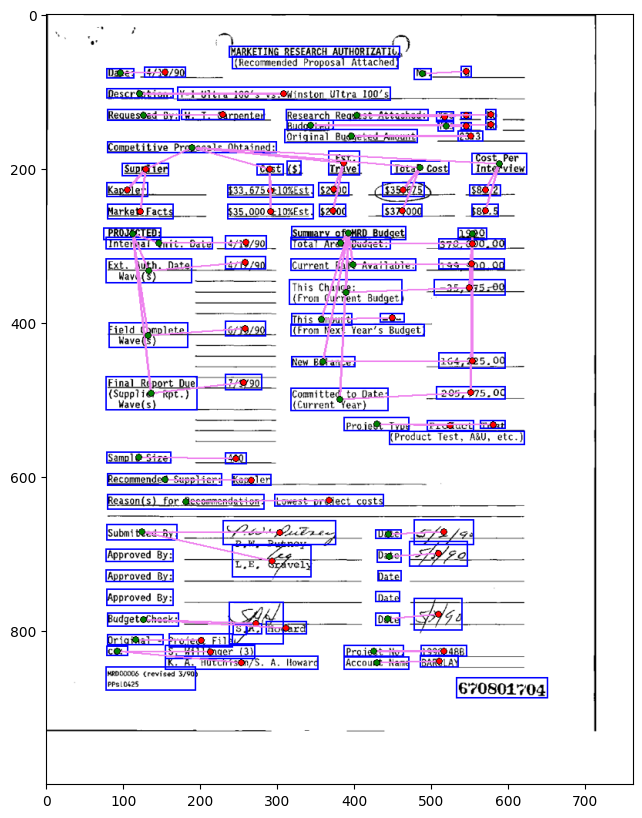

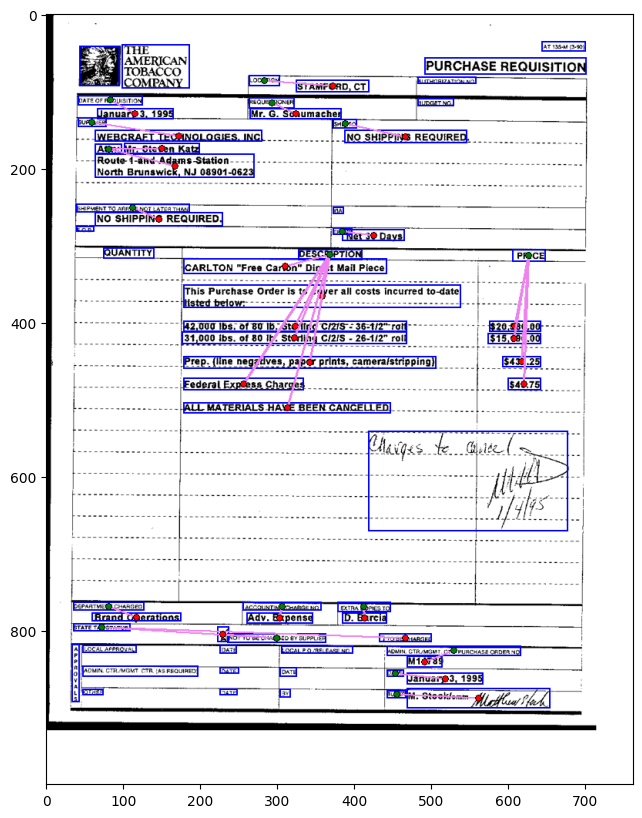

In [62]:
import matplotlib.pyplot as plt
import PIL

for i in range(15, 20):
    # PLot the image bigger
    plt.figure(figsize=(10, 10))
    plt.imshow(test.print_graph(graph=test.graphs[i]))
    plt.show()

In [40]:
import numpy as np

def get_encoding(coord):
    limit = 1 # High and with of the image after normalization
    return np.where(coord < limit / 2, np.where(coord < limit / 4, 11, 21), np.where(coord > limit / 4 * 3, 22, 12))


In [63]:
new = torch.cat((test.ndata['geom'], torch.from_numpy(get_encoding(test.ndata['geom']))), dim=1)

In [76]:
new[-1]

tensor([ 0.1287,  0.7370,  0.2870,  0.7500, 11.0000, 12.0000, 21.0000, 12.0000])

In [52]:
from typing import Tuple
from math import sqrt
import math
def polar(rect_src : list, rect_dst : list) -> Tuple[int, int]:
    """Compute distance and angle from src to dst bounding boxes (poolar coordinates considering the src as the center)
    Args:
        rect_src (list) : source rectangle coordinates
        rect_dst (list) : destination rectangle coordinates
    
    Returns:
        tuple (ints): distance and angle
    """
    
    # check relative position
    center = lambda rect: ((rect[2]+rect[0])/2, (rect[3]+rect[1])/2)

    # evaluate reciprocal position
    sc = center(rect_src)
    ec = center(rect_dst)
    new_ec = (ec[0] - sc[0], ec[1] - sc[1])
    angle = int(math.degrees(math.atan2(new_ec[1], new_ec[0])) % 360)
    
    return angle


In [3]:
def add_features(graphs):
    geom_polar = []
    for i in range(graphs.num_nodes()):
        edges = graphs.out_edges(i)
        edge_features = graphs.edata['feat'][edges[1].long()]
        geom_polar.append(torch.cat((graphs.ndata['geom'][i], edge_features.sum(dim=0))))

    geom_polar = torch.stack(geom_polar)
    graphs.ndata['geom_polar'] = geom_polar
    
train = dgl.batch(train.graphs)
test  = dgl.batch(test.graphs)

In [4]:
from typing import Tuple
def discrete_positions(rect_src : list, rect_dst : list) -> Tuple[int, int]:
    """Compute distance and angle from src to dst bounding boxes (poolar coordinates considering the src as the center)
    Args:
        rect_src (list) : source rectangle coordinates
        rect_dst (list) : destination rectangle coordinates
    
    Returns:
        tuple (ints): distance and angle
    """
    
    # check relative position
    left = (rect_dst[2] - rect_src[0]) <= 0
    bottom = (rect_src[3] - rect_dst[1]) <= 0
    right = (rect_src[2] - rect_dst[0]) <= 0
    top = (rect_dst[3] - rect_src[1]) <= 0
    
    vp_intersect = (rect_src[0] <= rect_dst[2] and rect_dst[0] <= rect_src[2]) # True if two rects "see" each other vertically, above or under
    hp_intersect = (rect_src[1] <= rect_dst[3] and rect_dst[1] <= rect_src[3]) # True if two rects "see" each other horizontally, right or left
    rect_intersect = vp_intersect and hp_intersect
    
    if rect_intersect:
        return 0 #'intersect'
    elif top and left:
        return 1 #'top_left'
    elif left and bottom:
        return 2 #'bottom_left'
    elif bottom and right:
        return 3 #'bottom_right'
    elif right and top:
        return 4 #'top_right'
    elif left:
        return 5 #'left'
    elif right:
        return 6 #'right'
    elif bottom:
        return 7 #'bottom'
    elif top:
        return 8 #'top'  
    
    #number2_position = {0:'intersect', 1:'top_left', 2:'bottom_left', 3:'bottom_right', 4:'top_right', 5:'left', 6:'right', 7:'bottom', 8:'top'}

In [5]:
def get_relative_positons(graphs):

    for graph in graphs:
        src, dst = graph.edges()
        discret_info = []
        for src_idx, dst_idx in zip(src, dst):
            src_idx = src_idx.item()
            dst_idx = dst_idx.item()
            relative_position = discrete_positions(graph.nodes[src_idx][0]['geom'][0], graph.nodes[dst_idx][0]['geom'][0])
            discret_info.append(relative_position)
        graph.edata['discrete_info'] = torch.tensor(discret_info)
    return graphs

In [6]:
from sklearn.model_selection import train_test_split
from dgl.data.utils import save_graphs, load_graphs
import dgl
import pickle

train_graphs, val_graphs, _, _ = train_test_split(data.graphs, torch.ones(len(data.graphs), 1), test_size=0.2, random_state=42)

#Graph for training
train_graphs = get_relative_positons(train_graphs)
train_graph = dgl.batch(train_graphs)
train_graph = train_graph.int()

with open('./src/train_graph.pkl', 'wb') as f:
    pickle.dump(train_graph, f)

In [7]:
#Graph for validating
val_graph = get_relative_positons(val_graphs)
val_graph = dgl.batch(val_graphs)
val_graph = val_graph.int()

#Saved validation graph
with open('./src/val_graph.pkl', 'wb') as f:
    pickle.dump(val_graph, f)

In [3]:
# Load the weights of the model
layers_dimensions = (1756, 400, 200, 100)
model = GSage_AE(layers_dimensions)
state_dict = torch.load(CHECKPOINTS / 'qualitative_results.pth')
model.load_state_dict(state_dict)


Encoder: ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=1756, out_features=1756, bias=True)
    (fc_self): Linear(in_features=1756, out_features=400, bias=False)
    (fc_neigh): Linear(in_features=1756, out_features=400, bias=False)
  )
  (1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=400, out_features=400, bias=True)
    (fc_self): Linear(in_features=400, out_features=200, bias=False)
    (fc_neigh): Linear(in_features=400, out_features=200, bias=False)
  )
  (2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=200, out_features=200, bias=True)
    (fc_self): Linear(in_features=200, out_features=100, bias=False)
    (fc_neigh): Linear(in_features=200, out_features=100, bias=False)
  )
) 	Numb Layers: 4

Decoder: ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=100, out_fe

<All keys matched successfully>

In [4]:
# Graph to try
import dgl
graphs = dgl.batch(test_data.graphs)

# Send to the gpu
criterion = torch.nn.MSELoss()
model = model.to('cuda:0')
graphs = graphs.to('cuda:0')
feat  = graphs.ndata['feat'].to('cuda:0')

In [6]:
# Calculate the prediction values
pred = model(graphs, feat)

### Emedding Visualization

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import dgl

def extract_embeddings(loader, model):
    model = model.to('cuda:0')
    graph = dgl.batch(loader.graphs).to('cuda:0')
    h = graph.ndata['feat'].to('cuda:0')
    for layer in model.encoder:
        h = layer(graph, h)
    
    val_embeddings = h
    labels = graph.ndata['label']
    return val_embeddings.cpu().detach().numpy(), labels.cpu().detach().numpy()
    
val_embeddings, labels = extract_embeddings(test_data, model)

t_sne = TSNE(n_components = 2, perplexity=45, n_iter=1000, init="pca")    
S_t_sne = t_sne.fit_transform(val_embeddings)


/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [26]:
fashion_mnist_classes = ["answer", "header", "other", "question"]
colors = ['#1f77b4', '#000000', '#2ca02c', '#d62728']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i], s=2)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)
    

In [35]:
import torch
from src.models.Drop_edge import E2E
import math
layers_dimensions = (1756, 600, 400, 100)
edge_pred_features = int((math.log2(8) + data.node_num_classes)*2)
model = E2E(node_classes = data.node_num_classes, 
                    edge_classes = data.edge_num_classes, 
                    dimensions_layers = layers_dimensions, 
                    dropout=0.2, 
                    edge_pred_features=edge_pred_features,
                    drop_rate = 0).to('cuda:0')

model.load_state_dict(torch.load(CHECKPOINTS / 'Run_2.pth'))

<All keys matched successfully>

In [37]:
 ["on top of", "vertically near", "horizontally near"]

ImportError: cannot import name 'compute_auc_mc' from 'src.evaluation' (/home/nbiescas/Desktop/CVC/CVC_internship/src/evaluation.py)

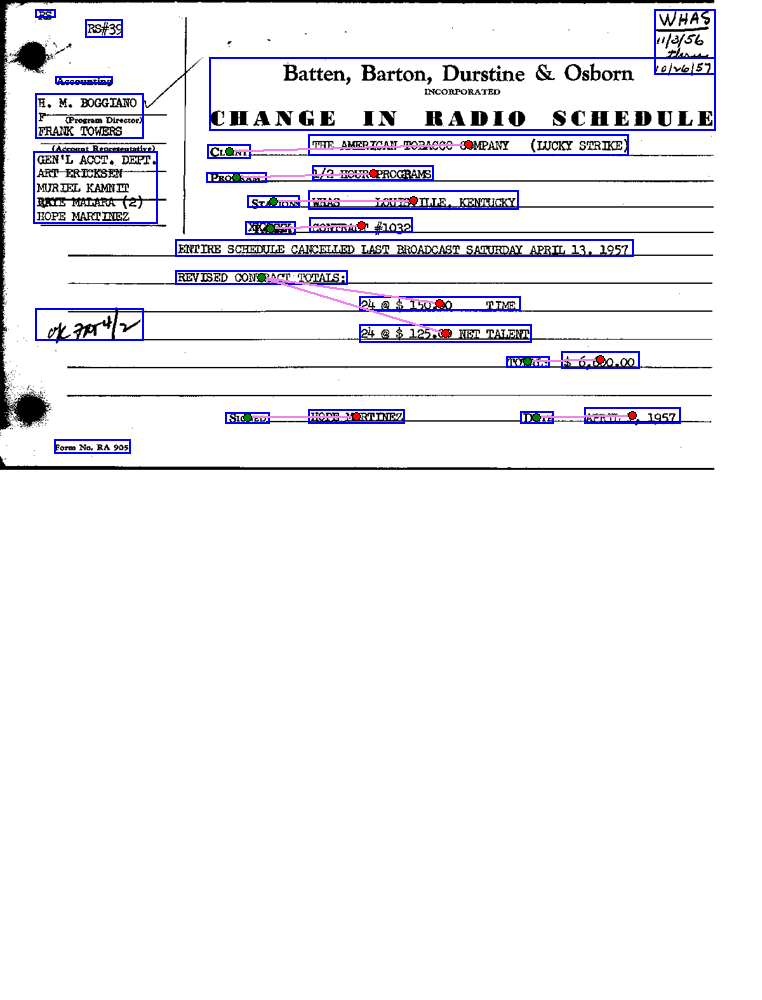

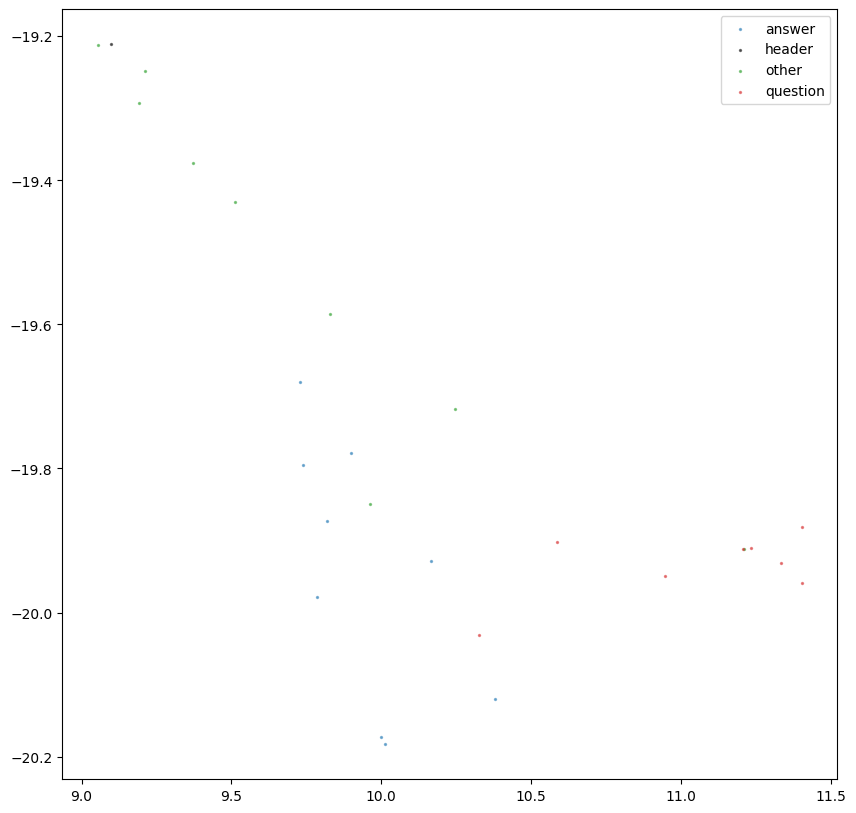

In [27]:
start = 0
num = 22
for i in range(num):
    start += test.graphs[i].num_nodes()

end = start + test.graphs[num].num_nodes()
test.graphs[num].num_nodes()
plot_embeddings(S_t_sne[start:end], labels[start:end])
test.print_graph(num)

In [1]:
import torch

/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
l = torch.tensor([[6,7,8,9,10], [5, 5, 5, 6, 7]])
s = torch.tensor([[1,2,3,4,5], [2,3,4,5,6]])
torch.cat((l, s), dim=1)

tensor([[ 6,  7,  8,  9, 10,  1,  2,  3,  4,  5],
        [ 5,  5,  5,  6,  7,  2,  3,  4,  5,  6]])

In [2]:
from sklearn.cluster import KMeans
import numpy as np


a = np.random.rand(100, 2)

In [4]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(a)

In [20]:
a = kmeans.labels_
counts = np.bincount(a)
print(np.argmax(counts))

0


In [19]:
np.where(kmeans.labels_ == 0)[0]

array([ 6, 12, 14, 20, 27, 30, 37, 42, 45, 46, 48, 49, 51, 52, 56, 57, 59,
       61, 64, 65, 67, 69, 72, 73, 74, 78, 79, 84, 90, 92, 94])